In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

2021-08-30 06:24:07.079553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 06:24:07.079599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
raw_df = pd.read_csv('../../../test-builds/llvm/datasets/model-aug-29.csv')
raw_df.head()

,fullpath,modulepath,function,BasicBlockCount,BasicBlockWithSingleSuccessor,BasicBlockWithTwoSuccessors,BasicBlockWithMoreThanTwoSuccessors,BasicBlockWithSinglePredecessor,BasicBlockWithTwoPredecessors,BasicBlockWithMoreThanTwoPredecessors,...,CastInstCount,FloatingPointInstCount,IntegerInstCount,LoadInstCount,StoreInstCount,CallInstCount,PHIInstCount,AllocaInstCount,GEPInstCount,label
0,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_GLOBAL__sub_I_APFixedPointTest.cpp,100,55,33,11,55,33,11,...,110,0,0,110,176,222,0,44,143,O2
1,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN10llvm_gtestlsERSoRKNS_14RawStreamProxyIA1...,7,3,3,0,4,1,1,...,5,0,1,4,8,7,1,1,12,FNF
2,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN10llvm_gtestlsERSoRKNS_14RawStreamProxyIN4...,3,1,1,0,1,1,0,...,5,0,0,4,7,9,0,2,11,O1-O2-O3-FNF
3,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN10llvm_gtestlsERSoRKNS_14RawStreamProxyIPKcEE,7,3,3,0,4,1,1,...,5,0,1,5,8,7,1,1,11,O1-O2-O3-FNF
4,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN12_GLOBAL__N_112CheckIntPartERKN4llvm19Fix...,148,65,74,0,95,38,14,...,86,0,48,94,53,147,4,33,92,O2


In [3]:
raw_df['label'].describe()

count            178012
unique               11
top        O1-O2-O3-FNF
freq              84434
Name: label, dtype: object

### Clean Dataset

In [4]:
cleaned_df = raw_df.copy()

# don't want the 'fullpath', 'modulepath', 'function' columns
cleaned_df = cleaned_df.drop(['fullpath', 'modulepath', 'function'], axis=1)

def clean_labels(x):
    if x.strip() == 'O1':
        return 1 
    elif x.strip() == 'O2':
        return 2 
    elif x.strip() == 'O3':
        return 3
    else:
        return 0
    

cleaned_df['label'] = cleaned_df['label'].map(clean_labels)

cleaned_df.head()        

,BasicBlockCount,BasicBlockWithSingleSuccessor,BasicBlockWithTwoSuccessors,BasicBlockWithMoreThanTwoSuccessors,BasicBlockWithSinglePredecessor,BasicBlockWithTwoPredecessors,BasicBlockWithMoreThanTwoPredecessors,BigBasicBlock,MediumBasicBlock,SmallBasicBlock,...,CastInstCount,FloatingPointInstCount,IntegerInstCount,LoadInstCount,StoreInstCount,CallInstCount,PHIInstCount,AllocaInstCount,GEPInstCount,label
0,100,55,33,11,55,33,11,0,22,78,...,110,0,0,110,176,222,0,44,143,2
1,7,3,3,0,4,1,1,0,1,6,...,5,0,1,4,8,7,1,1,12,0
2,3,1,1,0,1,1,0,0,1,2,...,5,0,0,4,7,9,0,2,11,0
3,7,3,3,0,4,1,1,0,1,6,...,5,0,1,5,8,7,1,1,11,0
4,148,65,74,0,95,38,14,0,7,141,...,86,0,48,94,53,147,4,33,92,2


### Examine the class label imbalance

In [57]:
np.bincount(cleaned_df['label'])

array([95945,  9763, 47887, 24417])

In [61]:
cleaned_df['label'].value_counts()

0    95945
2    47887
3    24417
1     9763
Name: label, dtype: int64

In [66]:
o_none, o1, o2, o3 = np.bincount(cleaned_df['label'])
total = o_none + o1 + o2 + o3
print(f'O1: {o1/total}')
print(f'O2: {o2/total}')
print(f'O3: {o3/total}')
print(f'O0: {o_none/total}')

O1: 0.05484461721681684
O2: 0.2690099543850976
O3: 0.13716491023077096
O0: 0.5389805181673145


### Split the dataframe into train, validation, and test

In [5]:
train, test = train_test_split(cleaned_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

113927 train examples
28482 validation examples
35603 test examples


### Create an input pipeline using tf.data

In [20]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    labels = pd.get_dummies(labels)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [21]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [22]:
train_ds

<PrefetchDataset shapes: ({ BasicBlockCount: (None,), BasicBlockWithSingleSuccessor: (None,), BasicBlockWithTwoSuccessors: (None,), BasicBlockWithMoreThanTwoSuccessors: (None,), BasicBlockWithSinglePredecessor: (None,), BasicBlockWithTwoPredecessors: (None,), BasicBlockWithMoreThanTwoPredecessors: (None,), BigBasicBlock: (None,), MediumBasicBlock: (None,), SmallBasicBlock: (None,), BlocksReachedFromConditionalInstruction: (None,), Uses: (None,), DirectCallsToDefinedFunctions: (None,), MaxLoopDepth: (None,), TopLevelLoopCount: (None,), IntegerConstantOccurrences: (None,), FloatingConstantOccurrences: (None,), InstructionCount: (None,), CastInstCount: (None,), FloatingPointInstCount: (None,), IntegerInstCount: (None,), LoadInstCount: (None,), StoreInstCount: (None,), CallInstCount: (None,), PHIInstCount: (None,), AllocaInstCount: (None,), GEPInstCount: (None,)}, (None, 4)), types: ({ BasicBlockCount: tf.int64, BasicBlockWithSingleSuccessor: tf.int64, BasicBlockWithTwoSuccessors: tf.int64

In [23]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of labels:', label_batch )

Every feature: [' BasicBlockCount', 'BasicBlockWithSingleSuccessor', 'BasicBlockWithTwoSuccessors', 'BasicBlockWithMoreThanTwoSuccessors', 'BasicBlockWithSinglePredecessor', 'BasicBlockWithTwoPredecessors', 'BasicBlockWithMoreThanTwoPredecessors', 'BigBasicBlock', 'MediumBasicBlock', 'SmallBasicBlock', 'BlocksReachedFromConditionalInstruction', 'Uses', 'DirectCallsToDefinedFunctions', 'MaxLoopDepth', 'TopLevelLoopCount', 'IntegerConstantOccurrences', 'FloatingConstantOccurrences', 'InstructionCount', 'CastInstCount', 'FloatingPointInstCount', 'IntegerInstCount', 'LoadInstCount', 'StoreInstCount', 'CallInstCount', 'PHIInstCount', 'AllocaInstCount', 'GEPInstCount']
A batch of labels: tf.Tensor(
[[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]], shape=(5, 4), dtype=uint8)


### preprocessing layers 

In [24]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

### Choose which columns to use

In [25]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [26]:
numeric_features = [' BasicBlockCount', 'BasicBlockWithSingleSuccessor', 'BasicBlockWithTwoSuccessors', 
                    'BasicBlockWithMoreThanTwoSuccessors', 'BasicBlockWithSinglePredecessor', 
                    'BasicBlockWithTwoPredecessors', 'BasicBlockWithMoreThanTwoPredecessors', 
                    'BigBasicBlock', 'MediumBasicBlock', 'SmallBasicBlock', 
                    'BlocksReachedFromConditionalInstruction', 'Uses', 'DirectCallsToDefinedFunctions', 
                    'MaxLoopDepth', 'TopLevelLoopCount', 'IntegerConstantOccurrences', 
                    'FloatingConstantOccurrences', 'InstructionCount', 'CastInstCount', 
                    'FloatingPointInstCount', 'IntegerInstCount', 'LoadInstCount', 'StoreInstCount', 
                    'CallInstCount', 'PHIInstCount', 'AllocaInstCount', 'GEPInstCount']

In [27]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in numeric_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

### Create, compile, and train the model

In [48]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(4, activation = 'softmax')(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])

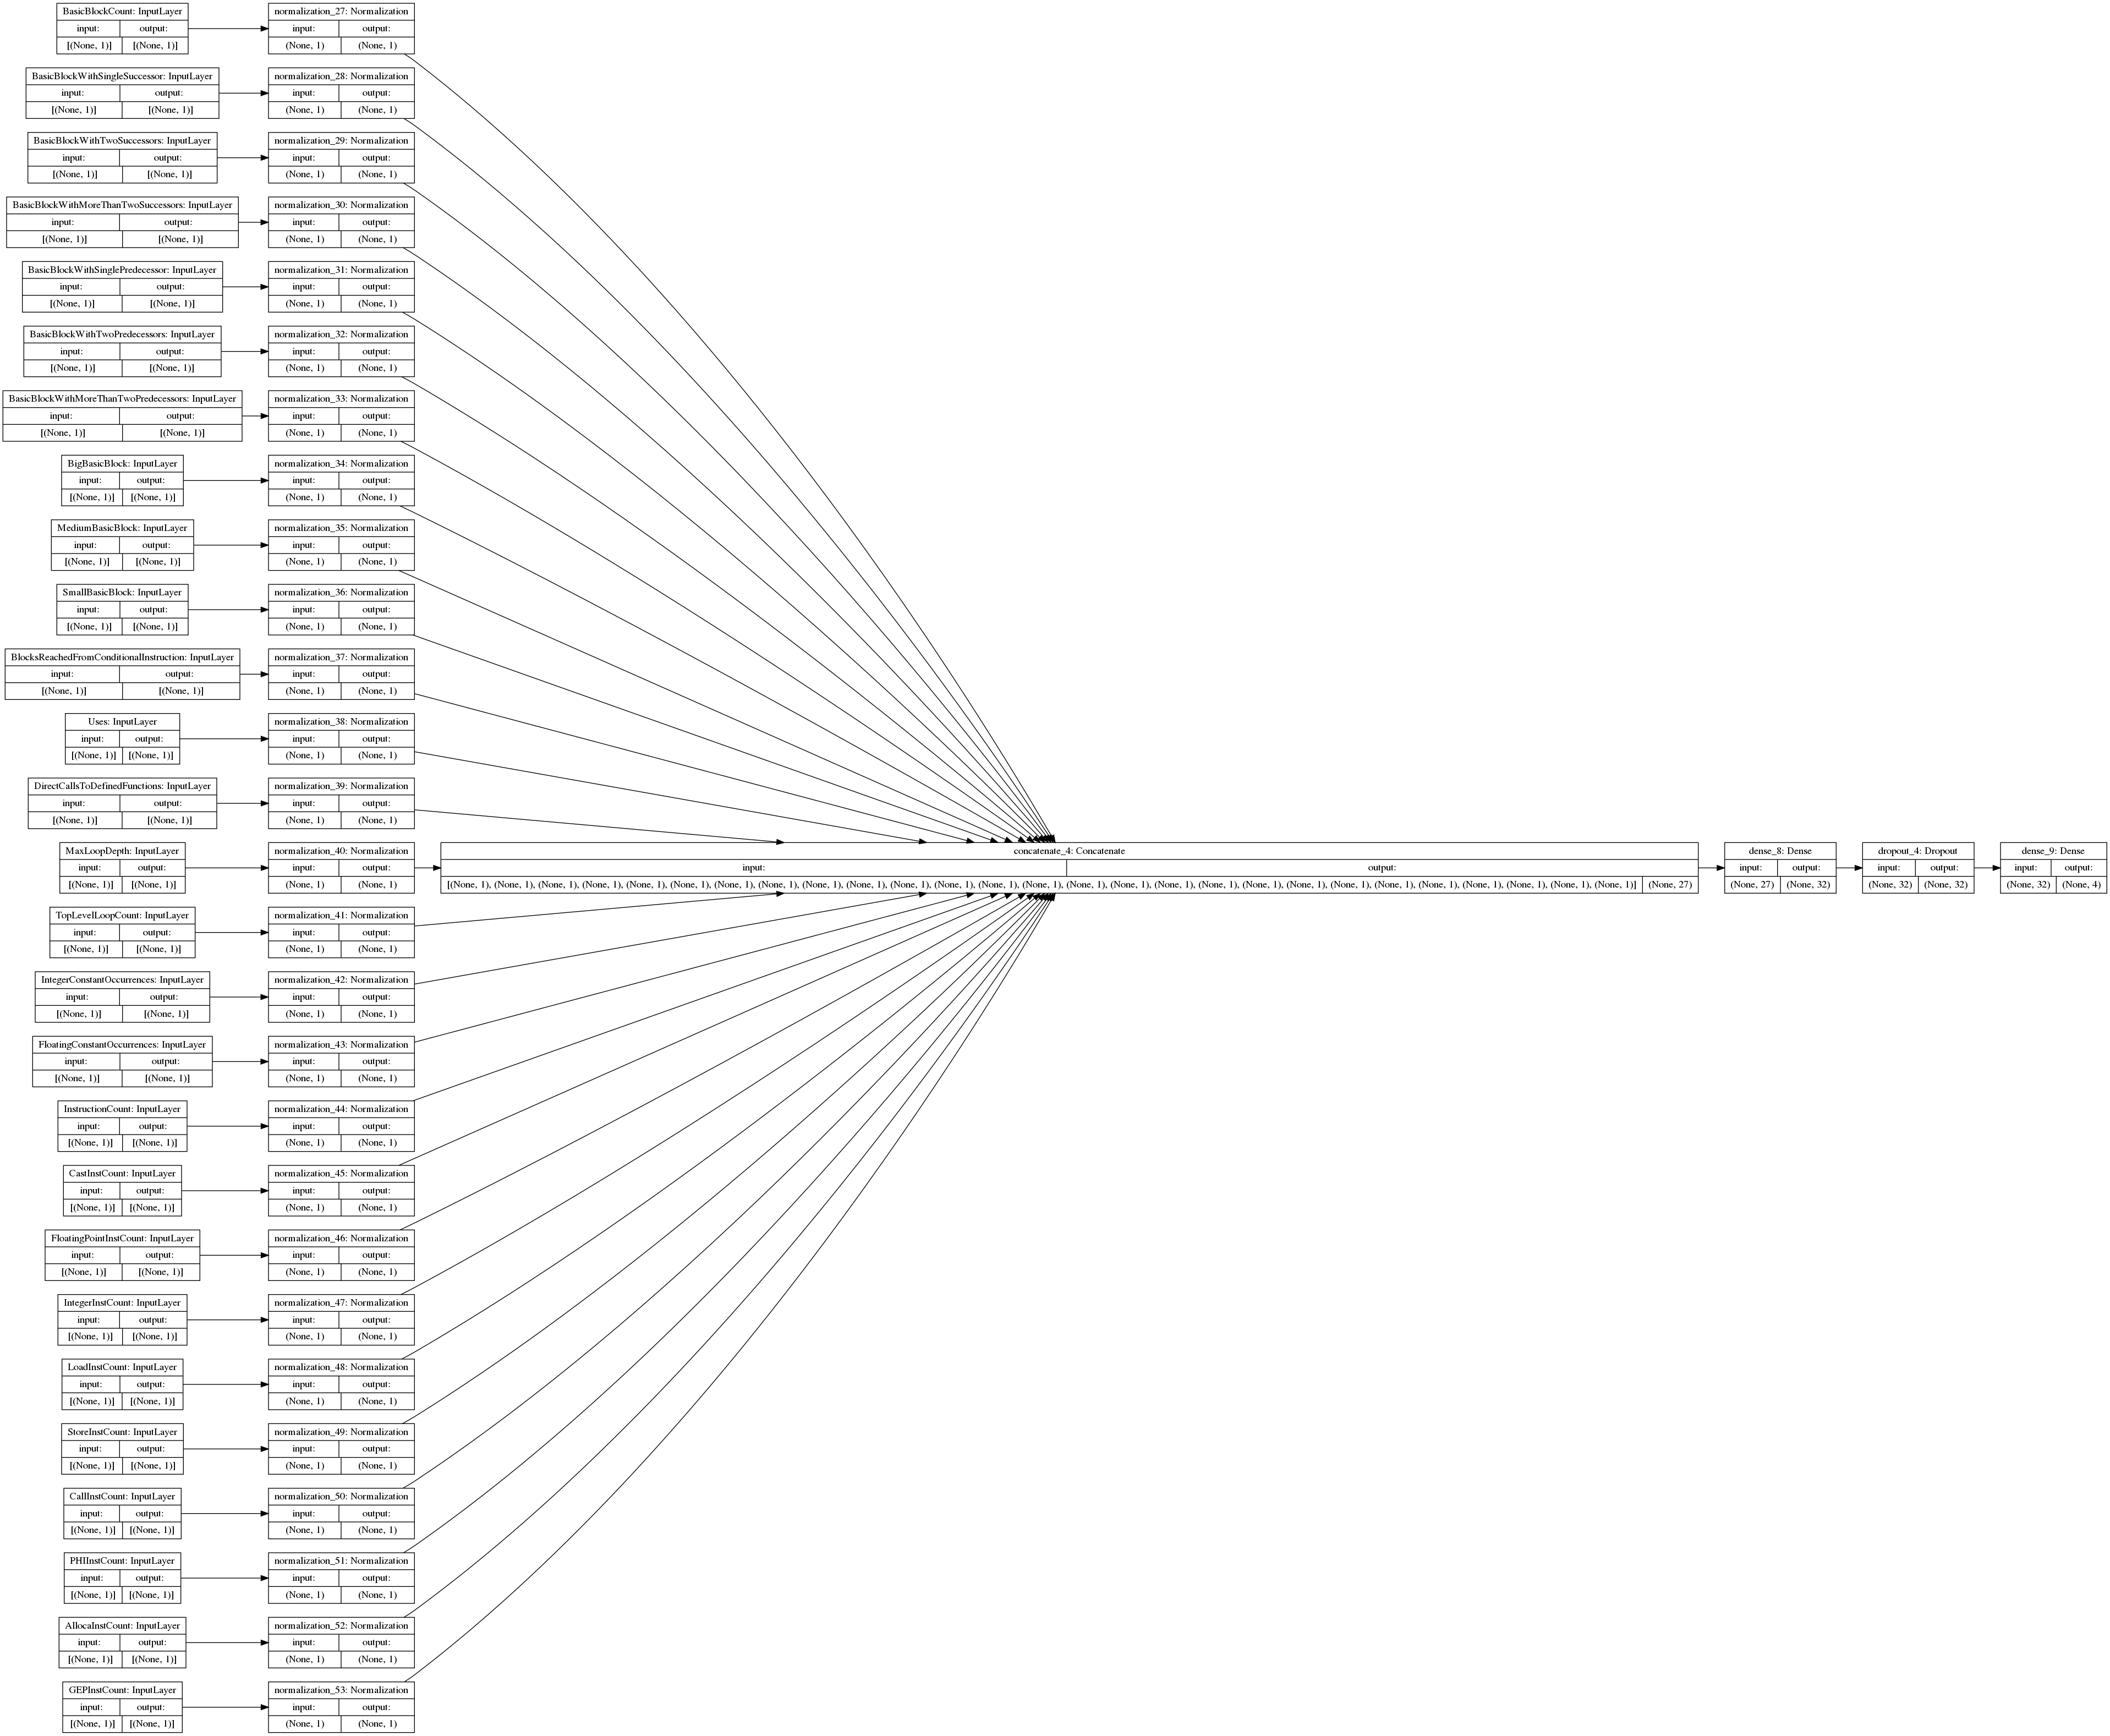

In [49]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the mode

In [50]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
446/446 [==============================] - 4s 5ms/step - loss: 1.0851 - accuracy: 0.5515 - val_loss: 0.9764 - val_accuracy: 0.5859
Epoch 2/10
446/446 [==============================] - 3s 4ms/step - loss: 0.9962 - accuracy: 0.5848 - val_loss: 0.9538 - val_accuracy: 0.5954
Epoch 3/10
446/446 [==============================] - 3s 4ms/step - loss: 0.9701 - accuracy: 0.5952 - val_loss: 0.9364 - val_accuracy: 0.6032
Epoch 4/10
446/446 [==============================] - 3s 4ms/step - loss: 0.9543 - accuracy: 0.6029 - val_loss: 0.9242 - val_accuracy: 0.6099
Epoch 5/10
446/446 [==============================] - 3s 4ms/step - loss: 0.9438 - accuracy: 0.6065 - val_loss: 0.9173 - val_accuracy: 0.6168
Epoch 6/10
446/446 [==============================] - 3s 4ms/step - loss: 0.9332 - accuracy: 0.6111 - val_loss: 0.9101 - val_accuracy: 0.6180
Epoch 7/10
446/446 [==============================] - 3s 4ms/step - loss: 0.9269 - accuracy: 0.6144 - val_loss: 0.9036 - val_accuracy: 0.6206
Epoch 

In [51]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

140/140 [==============================] - 0s 3ms/step - loss: 0.8941 - accuracy: 0.6248
Accuracy 0.6247507333755493


In [52]:
dict(cleaned_df.iloc[0])

{' BasicBlockCount': 100,
 'BasicBlockWithSingleSuccessor': 55,
 'BasicBlockWithTwoSuccessors': 33,
 'BasicBlockWithMoreThanTwoSuccessors': 11,
 'BasicBlockWithSinglePredecessor': 55,
 'BasicBlockWithTwoPredecessors': 33,
 'BasicBlockWithMoreThanTwoPredecessors': 11,
 'BigBasicBlock': 0,
 'MediumBasicBlock': 22,
 'SmallBasicBlock': 78,
 'BlocksReachedFromConditionalInstruction': 99,
 'Uses': 1,
 'DirectCallsToDefinedFunctions': 22,
 'MaxLoopDepth': 0,
 'TopLevelLoopCount': 0,
 'IntegerConstantOccurrences': 660,
 'FloatingConstantOccurrences': 0,
 'InstructionCount': 938,
 'CastInstCount': 110,
 'FloatingPointInstCount': 0,
 'IntegerInstCount': 0,
 'LoadInstCount': 110,
 'StoreInstCount': 176,
 'CallInstCount': 222,
 'PHIInstCount': 0,
 'AllocaInstCount': 44,
 'GEPInstCount': 143,
 'label': 2}

In [53]:
sample = {' BasicBlockCount': 100,
 'BasicBlockWithSingleSuccessor': 55,
 'BasicBlockWithTwoSuccessors': 33,
 'BasicBlockWithMoreThanTwoSuccessors': 11,
 'BasicBlockWithSinglePredecessor': 55,
 'BasicBlockWithTwoPredecessors': 33,
 'BasicBlockWithMoreThanTwoPredecessors': 11,
 'BigBasicBlock': 0,
 'MediumBasicBlock': 22,
 'SmallBasicBlock': 78,
 'BlocksReachedFromConditionalInstruction': 99,
 'Uses': 1,
 'DirectCallsToDefinedFunctions': 22,
 'MaxLoopDepth': 0,
 'TopLevelLoopCount': 0,
 'IntegerConstantOccurrences': 660,
 'FloatingConstantOccurrences': 0,
 'InstructionCount': 938,
 'CastInstCount': 110,
 'FloatingPointInstCount': 0,
 'IntegerInstCount': 0,
 'LoadInstCount': 110,
 'StoreInstCount': 176,
 'CallInstCount': 222,
 'PHIInstCount': 0,
 'AllocaInstCount': 44,
 'GEPInstCount': 143 }

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

In [54]:
tf.nn.sigmoid(predictions)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.52938706, 0.5003736 , 0.629069  , 0.5872472 ]], dtype=float32)>

In [55]:
predictions

array([[0.11768384, 0.00149449, 0.5282247 , 0.352597  ]], dtype=float32)